In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('train_tweets.csv')
test_data = pd.read_csv('test_tweets.csv')
print(train_data.shape)
print(test_data.shape)

(31962, 3)
(17197, 2)


In [3]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
train_data.isnull().any()
test_data.isnull().any()

id       False
tweet    False
dtype: bool

In [6]:
# checking out the negative comments from the train set

train_data[train_data['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [7]:
# checking out the postive comments from the train set 

train_data[train_data['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


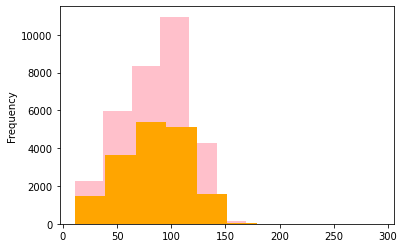

In [8]:
# checking the distribution of tweets in the data

length_train = train_data['tweet'].str.len().plot.hist(color = 'pink', figsize = (6, 4))
length_test = test_data['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

In [9]:
# adding a column to represent the length of the tweet

train_data['len'] = train_data['tweet'].str.len()
test_data['len'] = test_data['tweet'].str.len()

train_data.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,74
7,8,0,the next school year is the year for exams.ð...,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


In [10]:
test_data.head(10)

,id,tweet,len
0,31963,#studiolife #aislife #requires #passion #dedic...,90
1,31964,@user #white #supremacists want everyone to s...,101
2,31965,safe ways to heal your #acne!! #altwaystohe...,71
3,31966,is the hp and the cursed child book up for res...,142
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",93
5,31968,choose to be :) #momtips,27
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...,92
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...,85
8,31971,@user @user @user i will never understand why...,108
9,31972,#delicious #food #lovelife #capetown mannaep...,66


In [11]:
train_data.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

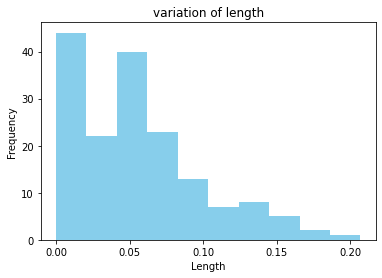

In [12]:
train_data.groupby('len').mean()['label'].plot.hist(color = 'skyblue', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

In [13]:
train_data['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

# Preparing Training Data

In [14]:
def drop_features(features, data):
    data.drop(features, inplace=True, axis=1)

In [15]:
def clean_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [16]:
train_data['cleaned_tweet'] = train_data['tweet'].apply(clean_tweet)
test_data['cleaned_tweet'] = test_data['tweet'].apply(clean_tweet)

In [17]:
train_data.head()

,id,label,tweet,len,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,102,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,122,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,21,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,86,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,39,factsguide society now motivation


In [18]:
test_data.head()

,id,tweet,len,cleaned_tweet
0,31963,#studiolife #aislife #requires #passion #dedic...,90,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,101,white supremacists want everyone to see the ne...
2,31965,safe ways to heal your #acne!! #altwaystohe...,71,safe ways to heal your acne altwaystoheal heal...
3,31966,is the hp and the cursed child book up for res...,142,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",93,3rd bihday to my amazing hilarious nephew eli ...


In [19]:
drop_features(['id','tweet'],train_data)
drop_features(['tweet'],test_data)

In [20]:
train_data.head()

,label,len,cleaned_tweet
0,0,102,when a father is dysfunctional and is so selfi...
1,0,122,thanks for lyft credit i can t use cause they ...
2,0,21,bihday your majesty
3,0,86,model i love u take with u all the time in ur
4,0,39,factsguide society now motivation


In [21]:
test_data.head()

,id,len,cleaned_tweet
0,31963,90,studiolife aislife requires passion dedication...
1,31964,101,white supremacists want everyone to see the ne...
2,31965,71,safe ways to heal your acne altwaystoheal heal...
3,31966,142,is the hp and the cursed child book up for res...
4,31967,93,3rd bihday to my amazing hilarious nephew eli ...


# Splitting training data into training and test set

In [22]:
x_train, x_test, y_train, y_test = train_test_split(train_data['cleaned_tweet'], train_data['label'], test_size=0.2, 
random_state=0)

In [23]:
count_vec = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2', sublinear_tf=True)

In [24]:
x_train_counts = count_vec.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [25]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(25569, 33693)
(25569, 33693)


In [26]:
x_test_counts = count_vec.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [27]:
print(x_test_counts.shape)
print(x_test_tfidf.shape)

(6393, 33693)
(6393, 33693)


In [28]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(x_train_tfidf, y_train)

RandomForestClassifier(n_estimators=200)

In [29]:
y_pred = clf.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
print ('\n Classification report:\n', classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9668387298607852

 Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5985
           1       0.92      0.53      0.67       408

    accuracy                           0.97      6393
   macro avg       0.94      0.76      0.83      6393
weighted avg       0.97      0.97      0.96      6393

[[5965   20]
 [ 192  216]]


# Tokenizing and normalizing training data and test data

In [30]:
train_counts = count_vec.fit_transform(train_data['cleaned_tweet'])
test_counts = count_vec.transform(test_data['cleaned_tweet'])

In [31]:
print(train_counts.shape)
print(test_counts.shape)

(31962, 38763)
(17197, 38763)


In [32]:
train_tfidf = transformer.fit_transform(train_counts)
test_tfidf = transformer.transform(test_counts)

In [33]:
print(train_tfidf.shape)
print(test_tfidf.shape)

(31962, 38763)
(17197, 38763)


In [34]:
clf.fit(train_tfidf, train_data['label'])

RandomForestClassifier(n_estimators=200)

In [35]:
pred = clf.predict(test_tfidf)

In [36]:
result = pd.DataFrame({'id': test_data['id'], 'label': pred})
result.to_csv('output.csv', index=False)